In [ ]:
#Preparing Kaggle API

!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#Download Fruit-360 Dataset

!kaggle datasets download -d moltean/fruits

 99% 1.28G/1.28G [00:11<00:00, 90.3MB/s]
100% 1.28G/1.28G [00:11<00:00, 119MB/s] 


In [ ]:
#Make directory and unzip the zipped datasets

!mkdir ./datasets
!unzip "fruits.zip" -d "datasets/"

Streaming output truncated to the last 5000 lines.
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: datasets/fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: datasets/fru

In [ ]:
#Import required libraries

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
#Instantiate the model and print the summary

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(131, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
#Freeze the base model layers (such as convolutions)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#Prepare the training and validation (test) dataset

BASE_DIR = "datasets/fruits-360_dataset/fruits-360/"
TRAINING_DIR = BASE_DIR + "Training/"
TEST_DIR = BASE_DIR + "Test/"
training_datagen = ImageDataGenerator(
    rescale=1/255.0,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=256
)

testing_datagen = ImageDataGenerator(
    rescale=1/255.0
)
test_generator = testing_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=256
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
#Write the class from dataset

import json
with open('fruit_classes.txt', 'w') as f:
  f.write(json.dumps(train_generator.class_indices))

### RMSProp

In [ ]:
#Compile the model using Adam

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Check the GPU availability

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8140297448991208025
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15173069290085168324
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
#Define the callback class

class Callback_Stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9):
      print("\nAccuracy and val_accuracy are above 90%, training progress will be stopped...")
      self.model.stop_training = True

In [ ]:
#Train the model using GPU

tf.keras.backend.clear_session()
callback = Callback_Stop()
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_generator,
        epochs=1000,
        validation_data=test_generator,
        steps_per_epoch=5,
        verbose=1,
        callbacks=[callback]
    )

Epoch 1/1000
5/5 [==============================] - 122s 25s/step - loss: 5.9634 - accuracy: 0.0594 - val_loss: 4.5906 - val_accuracy: 0.1173
Epoch 2/1000
5/5 [==============================] - 97s 24s/step - loss: 3.9400 - accuracy: 0.2125 - val_loss: 2.9116 - val_accuracy: 0.3152
Epoch 3/1000
5/5 [==============================] - 98s 24s/step - loss: 2.6315 - accuracy: 0.3766 - val_loss: 2.2826 - val_accuracy: 0.4461
Epoch 4/1000
5/5 [==============================] - 98s 24s/step - loss: 2.0126 - accuracy: 0.4914 - val_loss: 1.9073 - val_accuracy: 0.5242
Epoch 5/1000
5/5 [==============================] - 98s 24s/step - loss: 1.6330 - accuracy: 0.5969 - val_loss: 1.6973 - val_accuracy: 0.5843
Epoch 6/1000
5/5 [==============================] - 98s 24s/step - loss: 1.4104 - accuracy: 0.6273 - val_loss: 1.4740 - val_accuracy: 0.6194
Epoch 7/1000
5/5 [==============================] - 98s 24s/step - loss: 1.1737 - accuracy: 0.6969 - val_loss: 1.1796 - val_accuracy: 0.6914
Epoch 8/1000

In [ ]:
#Save the weight with RMSprop optimizer

model.save_weights('./RMSprop/')

In [ ]:
#Save the model

model.save('./RMSprop/model-rmsprop.h5')

### SGD

In [ ]:
#Compile the model using Adam

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Check the GPU availability

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8063518638973495518
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5550814289861110006
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
#Define the callback class

class Callback_Stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9):
      print("\nAccuracy and val_accuracy are above 90%, training progress will be stopped...")
      self.model.stop_training = True

In [ ]:
#Train the model using GPU

tf.keras.backend.clear_session()
callback = Callback_Stop()
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_generator,
        epochs=1000,
        validation_data=test_generator,
        steps_per_epoch=5,
        verbose=1,
        callbacks=[callback]
    )

Epoch 1/1000
5/5 [==============================] - 69s 13s/step - loss: 5.0641 - accuracy: 0.0141 - val_loss: 4.7683 - val_accuracy: 0.0290
Epoch 2/1000
5/5 [==============================] - 47s 12s/step - loss: 4.6344 - accuracy: 0.0570 - val_loss: 4.3576 - val_accuracy: 0.0917
Epoch 3/1000
5/5 [==============================] - 49s 12s/step - loss: 4.1788 - accuracy: 0.1297 - val_loss: 3.9218 - val_accuracy: 0.2204
Epoch 4/1000
5/5 [==============================] - 51s 12s/step - loss: 3.7044 - accuracy: 0.2641 - val_loss: 3.4706 - val_accuracy: 0.3267
Epoch 5/1000
5/5 [==============================] - 51s 13s/step - loss: 3.2346 - accuracy: 0.3648 - val_loss: 3.0410 - val_accuracy: 0.4027
Epoch 6/1000
5/5 [==============================] - 52s 13s/step - loss: 2.8724 - accuracy: 0.3891 - val_loss: 2.6311 - val_accuracy: 0.4657
Epoch 7/1000
5/5 [==============================] - 53s 13s/step - loss: 2.4087 - accuracy: 0.4883 - val_loss: 2.2665 - val_accuracy: 0.5374
Epoch 8/1000


In [ ]:
#Save the model weight with SGD optimizer

model.save_weights('./SGD/')

In [ ]:
#Save the model

model.save('./SGD/model-sgd.h5')

### Adam

In [ ]:
#Compile the model using Adam

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Check the GPU availability

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9070491459874900299
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11321147392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2976994101096051725
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
#Define the callback class

class Callback_Stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9):
      print("\nAccuracy and val_accuracy are above 90%, training progress will be stopped...")
      self.model.stop_training = True

In [ ]:
#Train the model using GPU

tf.keras.backend.clear_session()
callback = Callback_Stop()
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_generator,
        epochs=1000,
        validation_data=test_generator,
        steps_per_epoch=5,
        verbose=1,
        callbacks=[callback]
    )

Epoch 1/1000
5/5 [==============================] - 129s 27s/step - loss: 4.2754 - accuracy: 0.1625 - val_loss: 3.3226 - val_accuracy: 0.2892
Epoch 2/1000
5/5 [==============================] - 102s 25s/step - loss: 2.7488 - accuracy: 0.4000 - val_loss: 2.1842 - val_accuracy: 0.4957
Epoch 3/1000
5/5 [==============================] - 102s 25s/step - loss: 1.8255 - accuracy: 0.5492 - val_loss: 1.5898 - val_accuracy: 0.6025
Epoch 4/1000
5/5 [==============================] - 102s 25s/step - loss: 1.3713 - accuracy: 0.6375 - val_loss: 1.2144 - val_accuracy: 0.6930
Epoch 5/1000
5/5 [==============================] - 102s 25s/step - loss: 0.9879 - accuracy: 0.7234 - val_loss: 0.9851 - val_accuracy: 0.7456
Epoch 6/1000
5/5 [==============================] - 102s 25s/step - loss: 0.7066 - accuracy: 0.8109 - val_loss: 0.8851 - val_accuracy: 0.7661
Epoch 7/1000
5/5 [==============================] - 102s 25s/step - loss: 0.6594 - accuracy: 0.8328 - val_loss: 0.7336 - val_accuracy: 0.8025
Epoch 

In [ ]:
#Save the model weight with Adam optimizer

model.save_weights('./Adam/')

In [ ]:
#Save the model

model.save('./Adam/model-adam.h5')

### Test using other file

In [ ]:
#Import the required libraries

import os
import shutil
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
#Reconstruct the model

reconstructed_model = tf.keras.models.load_model('model-adam.h5')

In [ ]:
#Retrieve the dataset class (target)

def retrieve_classes(path=str):
  with open(path, 'r') as f:
    fruit_classes = json.loads(f.read())
  return fruit_classes

In [ ]:
#Define the function to looking for key in dictionary

def get_key(val):
  classes = retrieve_classes('fruit_classes.txt')
  for key, value in classes.items():
    if val == value:
      return key
 
  return "Key doesn't exist"

In [ ]:
#Define the function for predict

def predict(model, dir):
  img_dir = dir

  img = image.load_img(img_dir, target_size=(299,299))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  out = model.predict(img)
  predicted_label = np.argmax(out)
  label = get_key(predicted_label)
  return label

Saving test.jpg to test.jpg
The fruit predicted from the image is:  Watermelon 


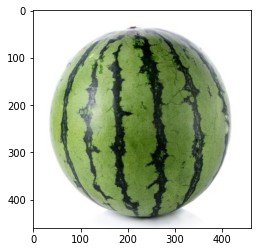

In [ ]:
#Upload the other file and predict it

f = files.upload()
for key in f:
  fname = key
if not os.path.exists('tmp'):
  os.makedirs('tmp')
os.rename(fname, 'tmp/'+fname)

img_dir = 'tmp/'+fname
label = predict(reconstructed_model, img_dir)
print('The fruit predicted from the image is: \033[1m', label, '\033[0m')
img = plt.imread(img_dir)
plt.imshow(img)
# shutil.rmtree(path='tmp/')